In [17]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url, InMemoryDataset
from torch_geometric.io import fs

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv, SAGEConv, GatedGraphConv, GATConv, TransformerConv
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import time 

## Dataset loading and preparing 

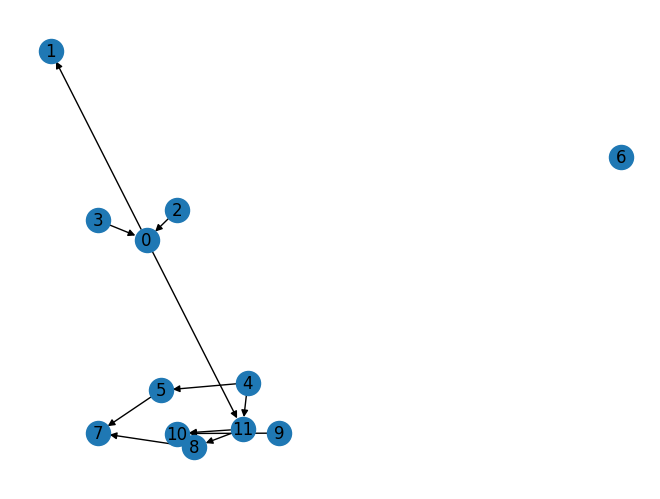

In [18]:
class LUCAS0Dataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(LUCAS0Dataset, self).__init__(root, transform, pre_transform)
        self.data = fs.torch_load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['lucas0_train.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        download_url('https://www.causality.inf.ethz.ch/data/lucas0_train.csv', self.raw_dir)

    def process(self):
        print(self.processed_paths)
        # Load in the data
        self.data = pd.read_csv(self.raw_paths[0])
        
        # Get the node features
        self._get_node_features()
        
        # Get the edge index
        self._get_edge_index()
    
        # Get the labels
        self._get_labels()
        
        # Save the data
        data = Data(x=self.X, edge_index=self.edge_index, y=self.y)
        
        # Save the data
        torch.save(data, osp.join(self.processed_dir, 'data.pt'))
        
        
    def _get_node_features(self):
        self.X = torch.tensor(self.data.values[:,:-1], dtype=torch.float).t()
        #self.X = self.X[:,:-1]
        
    
    def _get_edge_index(self):
        from_list = [2, 3, 0, 0 , 4 , 4, 5, 11, 11, 9 , 10, 8]
        to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8 , 10, 8 , 7]
        self.edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
        self.edge_index = torch.tensor(self.edges, dtype=torch.long).t().contiguous()
    
    
    def _get_labels(self):
        self.y = torch.tensor(self.data.Lung_cancer.values[:-1], dtype=torch.float)        


    def len(self):
        return len(self.processed_file_names)

dataset = LUCAS0Dataset(root='data/')[0]

# Visualize the graph
G = to_networkx(dataset)
nx.draw(G, with_labels=True)
plt.show()

In [19]:
df = pd.read_csv('data/raw/lucas0_train.csv')

In [20]:
print(df.columns)

Index(['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer'],
      dtype='object')


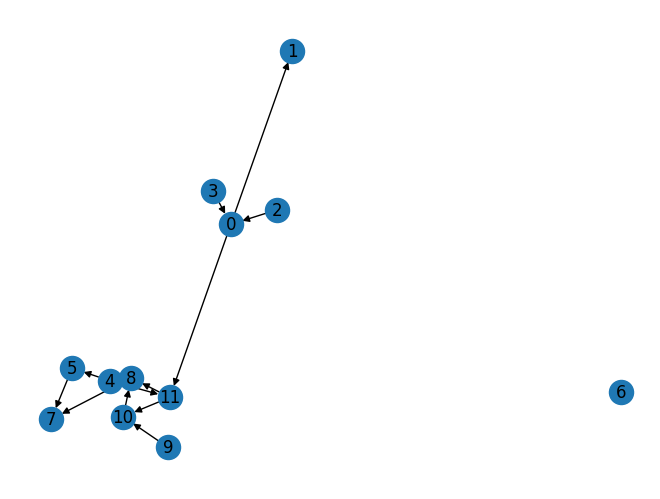

In [21]:
# Your tabular data
tabular_data = df.values

from_list = [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8]
to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7]

# Create graph data
edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

new = tabular_data[:,:-1]

# Node features
x = torch.tensor(tabular_data[:,:-1], dtype=torch.float).t()
y = torch.tensor(df.Lung_cancer.values, dtype=torch.float)


# Assuming there are no node labels or edge features in this example
data = Data(x=x, edge_index=edge_index, y=y)

# Plot the data using networkx
G = to_networkx(data)
nx.draw(G, with_labels=True)

In [25]:
# Your tabular data excluding the target
tabular_data = df.values[:,:-1]
split = int(tabular_data.shape[0] * 0.8)

from_list = [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8]
to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7]

# Create graph data
edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Node features with train and test split
x_train = torch.tensor(tabular_data[:split], dtype=torch.float).t()
x_test = torch.tensor(tabular_data[split:], dtype=torch.float).t()
y_train = torch.tensor(df.Lung_cancer.values[:split], dtype=torch.float)
y_test = torch.tensor(df.Lung_cancer.values[split:], dtype=torch.float)
x = torch.tensor(tabular_data, dtype=torch.float).t()
y = torch.tensor(df.Lung_cancer.values, dtype=torch.float)

# Assuming there are no node labels or edge features in this example
train_data = Data(x=x_train, edge_index=edge_index, y=y_train)
test_data = Data(x=x_test, edge_index=edge_index, y=y_test)
data = Data(x=x, edge_index=edge_index, y=y)

## Graph Neural Network

In [23]:
#graph neural network class 
class GCN_c(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN_c, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.conv4 = GCNConv(256, 128)
        self.conv5 = GCNConv(128, output_dim)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x

#train model function
def train_model(model, data, epochs=20, del_labels = []):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    #x = np.delete(data.x, del_labels, axis = 1)
    # Delete columns at specified indices
    result_tensor = torch.tensor(np.delete(data.edge_index.numpy(), del_labels, axis=1))

    # Delete corresponding rows
    result_tensor = result_tensor[result_tensor[:, :].sum(dim=1) != 0]

    model.train()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, result_tensor)
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()

        '''if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')'''

#predict function 
def predict(model, data, del_labels = []):
    model.eval()
    x = np.delete(data.x, del_labels, axis = 1)
    # Delete columns at specified indices
    result_tensor = torch.tensor(np.delete(data.edge_index.numpy(), del_labels, axis=1))

    # Delete corresponding rows
    result_tensor = result_tensor[result_tensor[:, :].sum(dim=1) != 0]
    with torch.no_grad():
        out = model(data.x, result_tensor)
        predicted_labels = torch.sigmoid(out)  # Sigmoid activation for binary classification
        return predicted_labels


In [24]:
# Define model dimensions
input_dim = 11  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

## Deleting one feature and then training

In [52]:
for i in range(len(labels)-1):
    model = GCN_c(input_dim, output_dim)


    # Train the model
    train_model(model, data, epochs=200, del_labels = [i])

    # Make predictions
    predictions = predict(model, data, del_labels = [i])

    # Evaluate the model accuracy
    accuracy = ((predictions > 0.5) == data.y).sum().item() / data.y.shape[0]**2
    print("Deleted label: "+str(labels[i]))
    print(f'Accuracy: {accuracy}')


Deleted label: Smoking
Accuracy: 0.5967955
Deleted label: Yellow_Fingers
Accuracy: 0.5932515
Deleted label: Anxiety
Accuracy: 0.599675
Deleted label: Peer_Pressure
Accuracy: 0.6025545
Deleted label: Genetics
Accuracy: 0.598346
Deleted label: Attention_Disorder
Accuracy: 0.5883785
Deleted label: Born_an_Even_Day
Accuracy: 0.5941375
Deleted label: Car_Accident
Accuracy: 0.5914795
Deleted label: Fatigue
Accuracy: 0.593916
Deleted label: Allergy
Accuracy: 0.5941375
Deleted label: Coughing
Accuracy: 0.589486


## Deleting two features 

In [15]:
# Define model dimensions
input_dim = tabular_data.shape[1]  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

for i in range(len(labels)):
    for j in range(len(labels)):
        model = GCN_c(input_dim, output_dim)


        # Train the model
        train_model(model, data, epochs=200, del_labels = [i,j])

        # Make predictions
        predictions = predict(model, data, del_labels = [i,j])

        # Evaluate the model accuracy
        accuracy = ((predictions > 0.5) == data.y).sum().item() / data.y.shape[0]**2
        print("Deleted label: "+str(labels[i])+", "+str(labels[j]))
        print(f'Accuracy: {accuracy}')

Deleted label: Smoking, Smoking
Accuracy: 0.5981245
Deleted label: Smoking, Yellow_Fingers
Accuracy: 0.5981245
Deleted label: Smoking, Anxiety
Accuracy: 0.598346
Deleted label: Smoking, Peer_Pressure
Accuracy: 0.5981245
Deleted label: Smoking, Genetics
Accuracy: 0.597903
Deleted label: Smoking, Attention_Disorder
Accuracy: 0.5981245
Deleted label: Smoking, Born_an_Even_Day
Accuracy: 0.5981245
Deleted label: Smoking, Car_Accident
Accuracy: 0.5981245
Deleted label: Smoking, Fatigue
Accuracy: 0.5981245
Deleted label: Smoking, Allergy
Accuracy: 0.5981245
Deleted label: Smoking, Coughing
Accuracy: 0.5981245
Deleted label: Smoking, Lung_cancer
Accuracy: 0.5981245


KeyboardInterrupt: 

## Visualizing feature importance 
this does not work well 

(2000, 1)


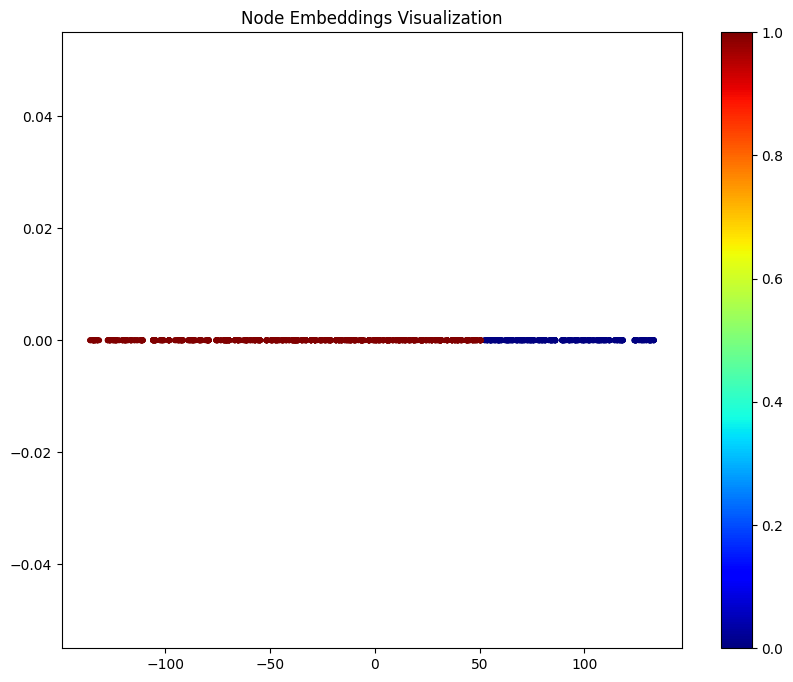

In [110]:

# Extract node embeddings
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index).detach().cpu().numpy()


# Reduce dimensionality for visualization
tsne = TSNE(n_components=1)
node_embeddings_2d = tsne.fit_transform(node_embeddings)
print(node_embeddings_2d.shape)

# Plot node embeddings
plt.figure(figsize=(10, 8))
domain = np.linspace(0,len(node_embeddings_2d),len(node_embeddings_2d))
zero = np.zeros(len(node_embeddings))
plt.scatter(node_embeddings_2d,zero, c=data.y.cpu(), cmap='jet', s=10)
plt.colorbar()
plt.title('Node Embeddings Visualization')
plt.show()

## Shap

In [128]:
import shap
import torch
from torch_geometric.data import Data

# Define a wrapper function for the GNN model
ind = data.edge_index
def model_wrapper(data):
    output = model(data, ind)  # Assuming model is your trained GNN model
    return output.detach().cpu().numpy()

# Create a background dataset (e.g., random noise)
background_data = torch.randn((1000, 12))

data_array = data.x.cpu().numpy() 

# Initialize an explainer object
explainer = shap.KernelExplainer(model_wrapper, data_array)


# Compute SHAP values
shap_values = explainer.shap_values(data.x, n_samples = 500)  # test_data should be a Data object containing the data you want to explain

# Visualize feature importance
shap.summary_plot(shap_values, features=data.x.numpy(), feature_names=['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']) 

Provided model function fails when applied to the provided data set.


AttributeError: 'numpy.ndarray' object has no attribute 't'

## Test features that don't matter

In [8]:
def featurematrix(data,feature):
    ''' Parameters:
            - data: in this form: data = Data(x=x, edge_index=edge_index, y=y)
            - feature: string of the feature that you want to test'''

    #get all the labels
    labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

    #find the index of the feature we want from labels
    index = labels.index(feature)
    selected_column_index = index 

    #set the mask to only get data we want from the row
    mask = (data.x[:, selected_column_index] == 1)

    #zero out everything except for the ones in the feature column we want 
    result_matrix = np.zeros_like(data.x)
    result_matrix[mask, selected_column_index] = 1


    return torch.tensor(result_matrix)

#train model function
def train_specific(model, data, feature, epochs=20):

    #setting random - I don't know if this actually does anything or matters  
    torch.manual_seed(42)
    np.random.seed(42)

    #set loss type and optimizer 
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=.01)

    #get our new training matrix with everything zeroed out except for the feature we want
    x = featurematrix(data,feature)

    #set to training mode 
    model.train()
    
    #train 
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(x, data.edge_index)
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()

        #if epoch % 10 == 0:
            #print(f'Epoch {epoch}, Loss: {loss.item()}')
        
def predict_specific(model, data, feature):

    #set to eval 
    model.eval()

    #zero out everything we don't want, keep feature column 
    x = featurematrix(data,feature)

    #evaluate 
    with torch.no_grad():
        out = model(x, data.edge_index)
        predicted_labels = torch.sigmoid(out)  # Sigmoid activation for binary classification
        return predicted_labels


In [62]:
#things we don't think affect lung cancer 
whatever = ['Anxiety', 'Peer_Pressure','Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident','Allergy','Smoking','Yellow_Fingers', 'Genetics']
# dimensions
input_dim = 11  # Number of input features
output_dim = 1 

for i in range(len(whatever)):

    #set random seed
    torch.manual_seed(42)
    np.random.seed(42)

    #reinitialize the model 
    model = GCN_c(input_dim, output_dim)

    # Train the model
    train_specific(model, data, whatever[i],epochs=20)

    # Make predictions
    predictions = predict_specific(model, data, whatever[i])

    # Evaluate the model accuracy
    accuracy = ((predictions > 0.74) == data.y).sum().item() / data.y.shape[0]**2
    print("Testing: "+whatever[i])
    print(f'Accuracy: {accuracy}')

Testing: Anxiety
Accuracy: 0.2787215
Testing: Peer_Pressure
Accuracy: 0.2796075
Testing: Attention_Disorder
Accuracy: 0.279386
Testing: Born_an_Even_Day
Accuracy: 0.278943
Testing: Car_Accident
Accuracy: 0.2791645
Testing: Allergy
Accuracy: 0.2796075
Testing: Smoking
Accuracy: 0.7215
Testing: Yellow_Fingers
Accuracy: 0.2796075
Testing: Genetics
Accuracy: 0.2800505


## All models

In [43]:
#graph neural network class 
class GCN_c(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN_c, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)

        self.conv6 = GCNConv(256, 512)
        self.conv7 = GCNConv(512, 256)

        self.conv4 = GCNConv(256, 128)
        self.conv5 = GCNConv(128, output_dim)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x

#chebyshev  
class GCN_ch(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN_ch, self).__init__()
        K = 1
        self.conv1 = ChebConv(input_dim, 64, K)
        self.conv2 = ChebConv(64, 128, K)
        self.conv3 = ChebConv(128, 256, K)

        self.conv6 = ChebConv(256, 512, K)
        self.conv7 = ChebConv(512, 256, K)

        self.conv4 = ChebConv(256, 128, K)
        self.conv5 = ChebConv(128, output_dim, K)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x
    
#sage 
class GCN_sage(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN_sage, self).__init__()
        K = 1
        self.conv1 = SAGEConv(input_dim, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 256)

        self.conv6 = SAGEConv(256, 512)
        self.conv7 = SAGEConv(512, 256)

        self.conv4 = SAGEConv(256, 128)
        self.conv5 = SAGEConv(128, output_dim)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x

#transformer  
class GCN_trans_big(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN_trans_big, self).__init__()
        K = 1
        self.conv1 = TransformerConv(input_dim, 64)
        self.conv2 =  TransformerConv(64, 128)
        self.conv3 =  TransformerConv(128, 256)
        self.conv6 = TransformerConv(256, 512)
        self.conv7 = TransformerConv(512, 1024)
        self.conv8 = TransformerConv(1024, 512)
        self.conv9 = TransformerConv(512, 256)
        self.conv4 =  TransformerConv(256, 128)
        self.conv5 =  TransformerConv(128, output_dim)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training) 
        '''x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training) 
        x = self.conv8(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)'''
        x = self.conv9(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training) 

    
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x
    
#transformer  
class GCN_trans(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN_trans, self).__init__()
        K = 1
        self.conv1 = TransformerConv(input_dim, 64)
        self.conv2 =  TransformerConv(64, 128)
        self.conv3 =  TransformerConv(128, 256)

        self.conv6 =  TransformerConv(256, 512)
        self.conv7 =  TransformerConv(512, 256)

        self.conv4 =  TransformerConv(256, 128)
        self.conv5 =  TransformerConv(128, output_dim)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x

#graph attention  
class GCN_gat(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN_gat, self).__init__()
        K = 1
        self.conv1 = GATConv(input_dim, 64)
        self.conv2 = GATConv(64, 128)
        self.conv3 = GATConv(128, 256)

        self.conv6 = GATConv(256, 512)
        self.conv7 = GATConv(512, 256)

        self.conv4 = GATConv(256, 128)
        self.conv5 = GATConv(128, output_dim)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x


## Additional functions

In [44]:
#train model function
def train(model, data, learnrate = .01, epochs=20):

    #set loss type and optimizer 
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learnrate)

    #set to training mode 
    model.train()
    
    #train 
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()

        #if epoch % 10 == 0:
            #print(f'Epoch {epoch}, Loss: {loss.item()}')
        
def predict(model, data):

    #set to eval 
    model.eval()

    #evaluate 
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        predicted_labels = torch.sigmoid(out.squeeze())  # Sigmoid activation for binary classification
        return predicted_labels

## Normal Convolutional 

In [45]:
# Define model dimensions
input_dim = 11 #tabular_data.shape[1]  # Number of input features
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

learning_rate = [.005, .001,  .01, .05]

for i in range(len(learning_rate)):

    model = GCN_c(input_dim, output_dim)
    print("LR: "+str(learning_rate[i]))

    # Train the model
    start = time.time()
    train(model, train_data, learning_rate[i], epochs=20)
    end = time.time() - start
    print("TIME: "+str(end))

    # Make predictions
    predictions = predict(model, test_data)
  
    accuracy = ((predictions > 0.5) == test_data.y).sum().item() / test_data.y.shape[0]
    print(f'Accuracy: {accuracy}')

LR: 0.005
TIME: 1.1710398197174072
Accuracy: 0.845
LR: 0.001
TIME: 0.853344202041626
Accuracy: 0.725
LR: 0.01
TIME: 0.883491039276123
Accuracy: 0.725
LR: 0.05
TIME: 1.0139529705047607
Accuracy: 0.725


## ChebyConv

In [49]:
# Define model dimensions
input_dim = 11 #tabular_data.shape[1]  # Number of input features
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

learning_rate = [.001, .005,  .01, .05]

for i in range(len(learning_rate)):

    model = GCN_ch(input_dim, output_dim)
    print("LR: "+str(learning_rate[i]))

    # Train the model
    start = time.time()
    train(model, train_data, learning_rate[i], epochs=20)
    end = time.time() - start
    print("TIME: "+str(end))

    # Make predictions
    predictions = predict(model, test_data)
  
    accuracy = ((predictions > 0.5) == test_data.y).sum().item() / test_data.y.shape[0]
    print(f'Accuracy: {accuracy}')



LR: 0.001
TIME: 0.787365198135376
Accuracy: 0.725
LR: 0.005
TIME: 0.6942257881164551
Accuracy: 0.725
LR: 0.01
TIME: 0.6859829425811768
Accuracy: 0.725
LR: 0.05
TIME: 0.658879280090332
Accuracy: 0.725


## SAGEConv 

In [47]:
# Define model dimensions
input_dim = 11 #tabular_data.shape[1]  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

for i in range(len(learning_rate)):

    model = GCN_sage(input_dim, output_dim)
    print("LR: "+str(learning_rate[i]))

    # Train the model
    start = time.time()
    train(model, train_data, learning_rate[i], epochs=200)
    end = time.time() - start 
    print("Time: "+str(end))

    # Make predictions
    predictions = predict(model, test_data)
    
    accuracy = ((predictions > 0.5) == test_data.y).sum().item() / test_data.y.shape[0]
    print(f'Accuracy: {accuracy}')

LR: 0.001
Time: 12.224848747253418
Accuracy: 0.8675
LR: 0.005
Time: 11.902665853500366
Accuracy: 0.8575
LR: 0.01
Time: 12.17830514907837
Accuracy: 0.865
LR: 0.05
Time: 13.525917053222656
Accuracy: 0.725


## GATConv - attention 

In [48]:
# Define model dimensions
input_dim = 11 #tabular_data.shape[1]  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

for i in range(len(learning_rate)):

    model = GCN_gat(input_dim, output_dim)
    print("LR: "+str(learning_rate[i]))

    # Train the model
    start = time.time()
    train(model, train_data, learning_rate[i], epochs=200)
    end = time.time() - start 
    print("Time: "+str(end))

    # Make predictions
    predictions = predict(model, test_data)
    
    accuracy = ((predictions > 0.5) == test_data.y).sum().item() / test_data.y.shape[0]
    print(f'Accuracy: {accuracy}')

LR: 0.001
Time: 10.135998010635376
Accuracy: 0.8125
LR: 0.005
Time: 10.027917861938477
Accuracy: 0.85
LR: 0.01
Time: 9.797966957092285
Accuracy: 0.855
LR: 0.05
Time: 9.968196153640747
Accuracy: 0.725


## Transformer Conv

In [41]:
# Define model dimensions
input_dim = 11 #tabular_data.shape[1]  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

for i in range(len(learning_rate)):

    model = GCN_trans(input_dim, output_dim)
    print("LR: "+str(learning_rate[i]))


    # Train the model
    start = time.time()
    train(model, data,learning_rate[i], epochs=200)
    end = time.time() - start 
    print("Time: "+str(end))

    # Make predictions
    predictions = predict(model, test_data)
    accuracy = ((predictions > 0.5) == test_data.y).sum().item() / test_data.y.shape[0]
    print(f'Accuracy: {accuracy}')

LR: 0.001
Time: 8.988303899765015
Accuracy: 0.8625
LR: 0.005
Time: 8.970470905303955
Accuracy: 0.875
LR: 0.01
Time: 8.959229946136475
Accuracy: 0.8775
LR: 0.05
Time: 9.840248823165894
Accuracy: 0.8675


## Bigger Transformer model

In [42]:
# Define model dimensions
input_dim = 11 #tabular_data.shape[1]  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

for i in range(len(learning_rate)):
    model = GCN_trans_big(input_dim, output_dim)


    # Train the model
    start = time.time()
    train(model, data, learning_rate[i], epochs=200)
    end = time.time() - start 
    print("Time: "+str(end))

    # Make predictions
    predictions = predict(model, data)
    # Make predictions
    
    accuracy = ((predictions > 0.5) == test_data.y).sum().item() / test_data.y.shape[0]
    print(f'Accuracy: {accuracy}')

Time: 99.52657318115234


RuntimeError: The size of tensor a (2000) must match the size of tensor b (400) at non-singleton dimension 0

## Adding new Dataloader

In [56]:
import networkx as nx
import torch
from torch_geometric.data import Data

# Load the Karate Club network using NetworkX
karate_g = nx.karate_club_graph()

# Convert the NetworkX graph to a PyTorch Geometric Data object
edge_index = torch.tensor(list(karate_g.edges)).t().contiguous()
x = torch.tensor([[1] if karate_g.nodes[i]['club'] == 'Mr. Hi' else [-1] for i in range(len(karate_g))], dtype=torch.float)
y = torch.tensor([karate_g.nodes[i]['club'] == 'Mr. Hi' for i in range(len(karate_g))], dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

Data(x=[34, 1], edge_index=[2, 78], y=[34])


In [59]:
print(edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  4,
          4,  5,  5,  5,  6,  8,  8,  8,  9, 13, 14, 14, 15, 15, 18, 18, 19, 20,
         20, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 26, 26, 27, 28, 28, 29,
         29, 30, 30, 31, 31, 32],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  2,  3,
          7, 13, 17, 19, 21, 30,  3,  7,  8,  9, 13, 27, 28, 32,  7, 12, 13,  6,
         10,  6, 10, 16, 16, 30, 32, 33, 33, 33, 32, 33, 32, 33, 32, 33, 33, 32,
         33, 32, 33, 25, 27, 29, 32, 33, 25, 27, 31, 31, 29, 33, 33, 31, 33, 32,
         33, 32, 33, 32, 33, 33]])


In [65]:
input_dim = 34 # Number of input features
hidden_dim = 64
output_dim = 1

model = GCN_c(input_dim, output_dim)


# Train the model
train_model(model, data, epochs=200)

# Make predictions
predictions = predict(model, data)

# Evaluate the model accuracy
accuracy = ((predictions > 0.5) == data.y).sum().item() / data.y.shape[0]**2
print("Deleted label: "+str(labels[i]))
print(f'Accuracy: {accuracy}')

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


RuntimeError: index 1 is out of bounds for dimension 0 with size 1

## Testing different probabilities

In [42]:
# P(Anxiety = T) = .64277 

df = pd.read_csv('data/raw/lucas0_train.csv')

from_list = [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8]
to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7]

# Create graph data
edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

tabular_data = df.values 
labels = df.columns
print(labels)

labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
              'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
              'Allergy', 'Coughing', 'Lung_cancer']
    
index = labels.index('Allergy')

x = torch.tensor(np.concatenate((tabular_data[:, :index], tabular_data[:, index+1:]), axis=1), dtype=torch.float).t()
y = torch.tensor(df.Anxiety.values, dtype=torch.float)

data = Data(x=x, edge_index=edge_index, y=y)

Index(['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer'],
      dtype='object')


In [43]:
def feature_specific(data, feature = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
                                                 'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
                                                 'Allergy', 'Coughing', 'Lung_cancer']):
    '''
    Parameters:
        - data: in this form: data = Data(x=x, edge_index=edge_index, y=y)
        - feature: string of the feature that you want to test
    '''

    # Get all the labels
    labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
              'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
              'Allergy', 'Coughing', 'Lung_cancer']

    # Find the index of the feature we want from labels
    indices = [labels.index(feature)]

    # Set the mask to only get data we want from the row
    mask = torch.any(data.x[:, indices] == 1, dim=1)

    # Zero out everything except for the columns in the indices list
    result_matrix = np.zeros_like(data.x)
    result_matrix[mask] = data.x[mask]

    return torch.tensor(result_matrix)

#train model function
def train_specific2(model, data, epochs=20):

    #setting random - I don't know if this actually does anything or matters  
    torch.manual_seed(42)
    np.random.seed(42)

    #set loss type and optimizer 
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=.01)

    tabular_data = df.values

    

    labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
              'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
              'Allergy', 'Coughing', 'Lung_cancer']
    
    '''index = labels.index(test)

    x = torch.tensor(tabular_data, dtype=torch.float)
    x = torch.cat((x[:, :index], x[:, index+1:]), dim=1)
    y = torch.tensor(x[:,index], dtype=torch.float)

    print(x.shape)'''

    #set to training mode 
    model.train()
    
    #train 
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()

        #if epoch % 10 == 0:
            #print(f'Epoch {epoch}, Loss: {loss.item()}')
        
def predict_specific2(model, data):

    #set to eval 
    model.eval()

    labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
              'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
              'Allergy', 'Coughing', 'Lung_cancer']

    #evaluate 
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        predicted_labels = torch.sigmoid(out)  # Sigmoid activation for binary classification
        return predicted_labels

In [62]:
#things we don't think affect lung cancer 
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
              'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
              'Allergy', 'Coughing', 'Lung_cancer']

for i in range(len(labels)):
    whatever = labels[i]
    # dimensions
    input_dim = 11  # Number of input features
    output_dim = 1 

    # P(Anxiety = T) = .64277 

    df = pd.read_csv('data/raw/lucas0_train.csv')
    tabular_data = df.values 
        
    index = labels.index(whatever)

    x = torch.tensor(np.concatenate((tabular_data[:, :index], tabular_data[:, index+1:]), axis=1), dtype=torch.float).t()
    y = torch.tensor(df[whatever].values, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, y=y)


    #set random seed
    torch.manual_seed(42)
    np.random.seed(42)

    #reinitialize the model 
    model = GCN_c(input_dim, output_dim)

    # Train the model
    train_specific2(model, data,epochs=20)

    # Make predictions
    predictions = predict_specific2(model, data)

    # Evaluate the model accuracy
    accuracy = ((predictions > 0.7) == y).sum().item() / y.shape[0]**2
    print("Predicting: "+whatever)
    print(f'Accuracy: {accuracy}')

Predicting: Smoking
Accuracy: 0.620695
Predicting: Yellow_Fingers
Accuracy: 0.643256
Predicting: Anxiety
Accuracy: 0.3695
Predicting: Peer_Pressure
Accuracy: 0.6585
Predicting: Genetics
Accuracy: 0.8605
Predicting: Attention_Disorder
Accuracy: 0.6775
Predicting: Born_an_Even_Day
Accuracy: 0.5105
Predicting: Car_Accident
Accuracy: 0.401657
Predicting: Fatigue
Accuracy: 0.457577
Predicting: Allergy
Accuracy: 0.657
Predicting: Coughing
Accuracy: 0.439449
Predicting: Lung_cancer
Accuracy: 0.4723125


In [61]:
column_totals = df.sum(axis=0)
column_totals_list = column_totals.values.tolist()
num_rows = df.shape[0]

percents = np.array(column_totals_list)/num_rows
cols = df.columns

for i in range(len(cols)):
    print(cols[i],percents[i])

Smoking 0.7525
Yellow_Fingers 0.782
Anxiety 0.6305
Peer_Pressure 0.3415
Genetics 0.1395
Attention_Disorder 0.3225
Born_an_Even_Day 0.4895
Car_Accident 0.723
Fatigue 0.737
Allergy 0.343
Coughing 0.7005
Lung_cancer 0.7215
